#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../scripts')
import diffusion_utils

import networkx as nx

from copy import deepcopy

from tqdm import tqdm

import random

## Star Network Belief Systems

#### Create the social network

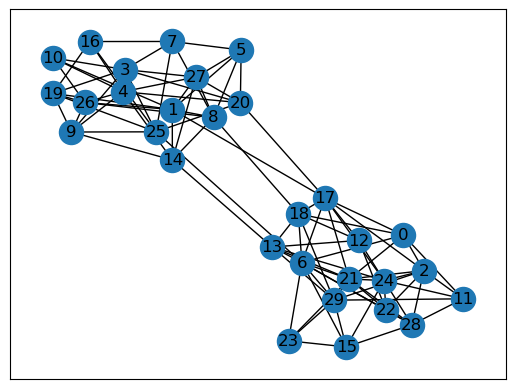

In [292]:
N = 30
M = 100
mu = .05

social_G, communities = diffusion_utils.community_social_network(N = N, mu = mu, M = M)

nx.draw_networkx(social_G)

#### Generate and embed the belief networks inside the social network

In [293]:
social_G = diffusion_utils.generate_embed_belief_networks_to_social_network(social_G, communities)

#### Random walk to close triads

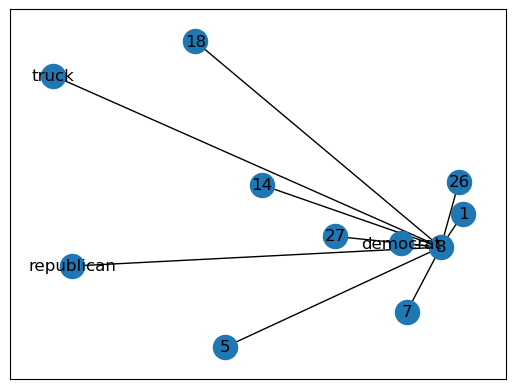

In [294]:
g = social_G.nodes[8]['belief_network']

nx.draw_networkx(g)

In [295]:
del g

In [296]:
def get_avg_measures(social_G):
    
    temp1 = {'intra-group':[], 'inter-group':[], 'aggregate':[]}
    temp2 = {'intra-group':[], 'inter-group':[], 'aggregate':[]}

    for e in social_G.edges():
        w1 = social_G.nodes[e[0]]['belief_network'].edges[e]['weight']
        w2 = social_G.nodes[e[1]]['belief_network'].edges[e]['weight']

        diff = abs(w1 - w2)
        comm1 = communities[e[0]] + "s"
        comm2 = communities[e[1]] + "s"
        
        if comm1 != comm2:
            temp1['inter-group'].append(diff)
            temp2['inter-group'].append(w1)
            temp2['inter-group'].append(w2)
        else:
            temp1['intra-group'].append(diff)
            temp2['intra-group'].append(w1)
            temp2['intra-group'].append(w2)
        
        temp1['aggregate'].append(diff)
        temp2['aggregate'].append(w1)
        temp2['aggregate'].append(w2)
    
    return temp1, temp2

In [297]:
def random_walker(g, focal_edge):
    
    node_order = list(g.nodes())
    #print("Node Order:", node_order)

    # Create mappings
    index_to_node = {i: node for i, node in enumerate(node_order)}
    node_to_index = {node: i for i, node in enumerate(node_order)}
    
    # get the adjacency matrix
    adj = nx.adjacency_matrix(g)

    # take the absolute value of all
    abs_adj = abs(adj)

    # sum of columns will be used to normalize the values
    normalizer = abs_adj.sum(axis=0)

    # normalize the values columnwise
    abs_adj_normalized = abs_adj/normalizer

    # probabilities for a two-step random walk
    random_walk_probs = (abs_adj_normalized**2).todense()

    # choose one of the nodes from the edge as the starter node
    i = np.random.choice([0,1])
    starting_node = focal_edge[i]
    middle_node = focal_edge[i-1]

    # determine the column number of the middle node in the adj matrix
    col = node_to_index[middle_node]

    # extract the probabilities that starting from the starter node,
    # what are the probabilities ending up in the other nodes in k jumps?
    probabilities = random_walk_probs[:,col].flatten()

    # choose a node depending on the probabilities
    ending_node = random.choices(node_order, weights=probabilities, k=1)[0]

    return starting_node, middle_node, ending_node

In [298]:
def assign_weight_to_new_edge(g, starting_node, middle_node, ending_node):
    
    # compute the multiplication of starting to middle and middle to ending node edges
    curr_multiplication = g.edges[(starting_node, middle_node)]['weight'] * g.edges[(middle_node, ending_node)]['weight']
    
    # assign a random initial weight drawn from normal distribution that ensures cognitive
    # consonance for the triad

    dissonant = True

    while dissonant:
        initial_weight = np.random.normal(0, .2)
        if curr_multiplication * initial_weight < 0:
            dissonant = False
    
    return initial_weight

In [ ]:
N = 30
M = 100
mu = .05

networks = {}
log = {}

for sim in range(50):
    
    # initialize the social network
    social_G, communities = diffusion_utils.community_social_network(N = N, mu = mu, M = M)

    # embed the belief networks into social networks
    social_G = diffusion_utils.generate_embed_belief_networks_to_social_network(social_G, communities)
    
    #networks[0] = deepcopy(social_G)

    avg_diff = {'intra-group':[], 'inter-group':[], 'aggregate':[]}
    avg_w = {'intra-group':[], 'inter-group':[], 'aggregate':[]}
    
    T = N * 800
    
    for t in tqdm(range(T+1)):
        
        # Randomly choose a sender, receiver and focal edge
        sender, receiver, focal_edge = diffusion_utils.choose_sender_receiver_mutual_belief(social_G)
        
        # republican and democrat beliefs do not change
        if ('republican' not in focal_edge) & ('democrat' not in focal_edge):
            
            # Calculate the updated weight after agents interact
            b_i_plus_1 = diffusion_utils.calculate_updated_weight(social_G, sender, receiver, 
                                                                  focal_edge, alpha=1.5, beta=1)
            
            # Update the belief in the network
            diffusion_utils.embed_b_i_plus_1_to_belief_network(social_G, receiver, focal_edge, 
                                                               b_i_plus_1)
        
        # Extract the receiver's belief network
        g = social_G.nodes[receiver]['belief_network']
        
        # Agent thinks to themselves after updating their belief (apply random walk)
        starting_node, middle_node, ending_node = random_walker(g, focal_edge)
        
        # If starting node is the same as the ending node or the edge already exists,
        # we cannot change anything ...
        if (starting_node != ending_node) & ~(g.has_edge(starting_node, ending_node)):
            # ... if not, we randomly assign a weight to the new edge
            initial_weight = assign_weight_to_new_edge(g, starting_node, middle_node,
                                                       ending_node)
            
            # Connect starting and ending nodes to each other with the initial weight
            g.add_edge(starting_node, ending_node, weight=initial_weight)
            
            # Put the receiver's belief network back (might be done automatically)
            social_G.nodes[receiver]['belief_network'] = g
        
        temp1, temp2 = get_avg_measures(social_G)
        
        for k,v in temp1.items():
            avg_diff[k].append(np.mean(v))
        
        for k,v in temp2.items():
            avg_w[k].append(np.mean(v))

        #if t % 500 == 0:
        #    networks[t] = deepcopy(social_G)
    
    log[sim] = {}
    log[sim]['avg_diff'] = avg_diff
    log[sim]['avg_w'] = avg_w
    
    break

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 17335/24001 [00:48<00:52, 128.11it/s]

Community: republican
Weight toward republican: {'weight': 1}
Weight toward democrat: {'weight': -1}


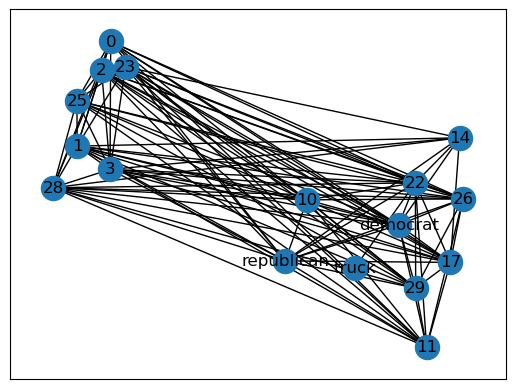

In [262]:
node = 22
nx.draw_networkx(social_G.nodes[node]['belief_network'])

print("Community:", communities[node])

print("Weight toward republican:", social_G.nodes[node]['belief_network'].edges[(node,'republican')])
print("Weight toward democrat:", social_G.nodes[node]['belief_network'].edges[(node,'democrat')])

In [263]:
# find neighbors and select one
neighbor = random.choice([*social_G.neighbors(node)])
print(neighbor)
communities[neighbor]

29


'democrat'

In [264]:
social_G.nodes[node]['belief_network'].edges[(node,neighbor)]

{'weight': -1}

In [265]:
social_G.nodes[neighbor]['belief_network'].edges[(node,neighbor)]

{'weight': -1}

In [266]:
avg

nan

/var/folders/ps/0k9vhym53qx049gtsg7sc_nm0000gq/T/ipykernel_62230/2972752697.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


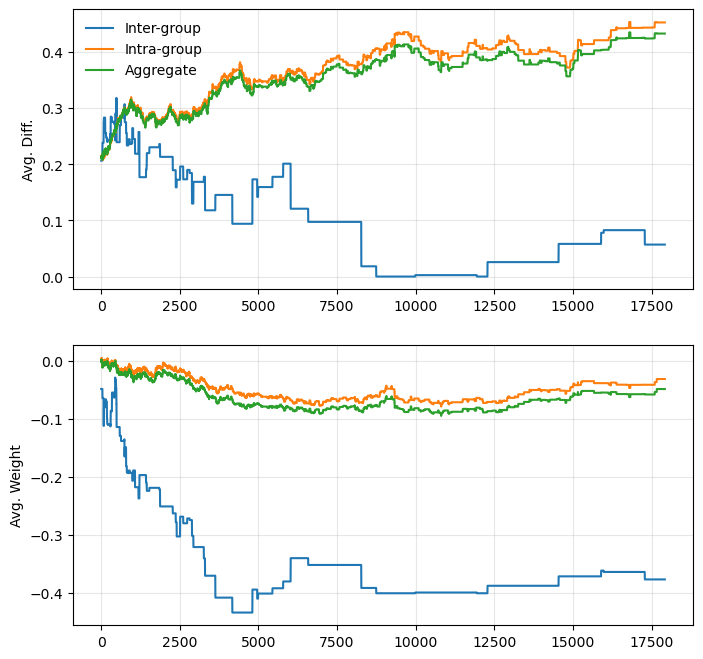

In [278]:
fig, axs = plt.subplots(2,1,figsize=(8,8))

for i, d, ylabel in zip([0,1], ['avg_diff', 'avg_w'], ['Avg. Diff.', 'Avg. Weight']):
    for l in ['inter-group', 'intra-group', 'aggregate']:
        avg = np.mean([v[d][l] for v in log.values()], axis=0)
        std = np.std([v[d][l] for v in log.values()], axis=0)
        axs[i].plot(avg, 
                    label=l.capitalize())
        
        axs[i].fill_between(range(len(avg)),
                            avg+(std/2), avg-(std/2),
                            alpha=.3)
    
    axs[i].set_ylabel(ylabel)
    axs[i].grid(alpha=.3)
    
axs[0].legend(frameon=False)

fig.show()

In [275]:
[social_G.nodes[n]['belief_network'].edges[('democrat', 'republican')]['weight'] for n in social_G.nodes if social_G.nodes[n]['belief_network'].has_edge('republican','democrat')]

[0.1573629601906707,
 0.2643044306790425,
 0.2090122481002215,
 0.16946705125186215,
 0.33627693413261484,
 0.47541217776409406,
 0.5540890279487362,
 0.06433750868185399,
 0.27921837152188056,
 0.20808651371177722,
 0.21323087132289992,
 0.5236284413206802,
 0.27209137465505506,
 0.39048370046857117,
 0.18887114183247156,
 0.03167340674703155,
 -0.024008447583114118,
 0.05826775892183689,
 0.11688128022627742,
 0.2874014765547623,
 0.06576209047859025,
 0.01935075013929222,
 0.2635306126330565,
 0.03963617190856827,
 0.15124361211148274,
 0.16049646011218113,
 0.15508720803929626,
 0.09371434087004776,
 0.14229324400900487]

In [277]:
[social_G.nodes[n]['belief_network'].edges[(n, 'democrat')]['weight'] for n in social_G.nodes if social_G.nodes[n]['belief_network'].has_edge('republican','democrat')]

[-1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1]

In [271]:
social_G.nodes[4]['belief_network'].edges

EdgeView([(4, 13), (4, 12), (4, 7), (4, 19), (4, 18), (4, 8), (4, 16), (4, 6), (4, 29), (4, 5), (4, 27), (4, 24), (4, 9), (4, 21), (4, 'democrat'), (4, 'republican'), (4, 'truck'), (13, 21), (13, 16), (13, 6), (13, 12), (13, 24), (13, 29), (13, 18), (13, 5), (13, 19), (13, 9), (13, 27), (13, 7), (13, 'republican'), (13, 'democrat'), (13, 8), (12, 21), (12, 'democrat'), (12, 6), (12, 24), (12, 16), (12, 29), (12, 7), (12, 8), (12, 'republican'), (12, 27), (12, 18), (12, 19), (12, 5), (12, 9), (7, 16), (7, 19), (7, 'republican'), (7, 27), (7, 21), (7, 'democrat'), (7, 5), (7, 24), (7, 18), (7, 8), (7, 6), (7, 29), (7, 9), (19, 'democrat'), (19, 'republican'), (19, 27), (19, 29), (19, 16), (19, 21), (19, 24), (19, 6), (19, 18), (19, 8), (19, 5), (19, 9), (18, 8), (18, 'republican'), (18, 24), (18, 'democrat'), (18, 21), (18, 29), (18, 16), (18, 27), (18, 5), (8, 27), (8, 'democrat'), (8, 'republican'), (8, 16), (8, 24), (8, 21), (8, 29), (8, 9), (8, 6), (16, 24), (16, 21), (16, 29), (16, 